In [63]:
using Revise
using ObjectiveEmpiricalBayes
import ObjectiveEmpiricalBayes: OptConfig, Transformation, FEModel, generatedata, transformmodel, 
    ReferenceRegularizer, ThikonovRegularizer, cvscore, ebprior, compareplot, likelihoodmat

using Random: seed!
using Distributions
using PyPlot
using CSV
using LinearAlgebra
linspace(x...) = LinRange(x...) |> collect

OPTCONFIG=OptConfig(XTOLABS=1e-8, DEBUG=true);

In [2]:
table = CSV.read("baseballdata.csv")

,FirstName,LastName,At-Bats,Hits,BattingAverage,RemainingAt-Bats,RemainingHits
,String,String,Int64,Int64,Float64,Int64,Int64
1,Roberto,Clemente,45,18,0.4,367,127
2,Frank,Robinson,45,17,0.378,426,127
3,Frank,Howard,45,16,0.356,521,144
4,Jay,Johnstone,45,15,0.333,275,61
5,Ken,Berry,45,14,0.311,418,114
6,Jim,Spencer,45,14,0.311,466,126
7,Don,Kessinger,45,13,0.289,586,155
8,Luis,Alvarado,45,12,0.267,138,29
9,Ron,Santo,45,11,0.244,510,137


In [191]:
xs = linspace(0.1,.5,300)

data = table[:,:BattingAverage]
M = length(data)
N = 45
σ = sqrt(mean(data) * (1 - mean(data)) / N)

0.06582090626055082

In [192]:
function cverp(m, data; ncv=10, rs = linspace(0.01,0.1,ncv))
    regs = [ReferenceRegularizer(m, r) for r in rs]
    @time ss = [cvscore(m, data, dd->ebprior(m, dd, r, OPTCONFIG)) for r in regs]
    @show reg = rs[argmax(ss)]
    plot(rs, ss)
    ebprior(m,  data, ReferenceRegularizer(m,  reg), OPTCONFIG), reg
end

cverp (generic function with 4 methods)

In [ ]:
B = 1 - (M - 3) * σ^2 / sum((data .- mean(data)).^2)
μ_js = mean(data)
σ_js = sqrt(B * σ^2 / (1 - B))

w_js = normalize(pdf.(Normal(μ_js, σ_js), xs), 1);

In [ ]:
m = FEModel(f=x->x, xs=xs, σ=σ)

w_er, reg = cverp(m, data, rs = linspace(0.0405,0.041,10))

In [255]:
function posteriors(w)
    L=likelihoodmat(m, data)
    post = w .* L'
    post = post ./ sum(post, dims=1)
end

posteriormeans(w) = posteriors(w)' * xs

truth = table[:, :RemainingHits] ./ table[:, Symbol("RemainingAt-Bats")]

function errors(w)
    posteriormeans(w) - truth
end

mse(w) = mean(x->x^2, errors(w))

mse (generic function with 1 method)

In [ ]:
plot(hcat(errors(w_js), errors(w_er)))

In [207]:
@show mse(w_js);
@show mse(w_er);

mse(w_js) = 0.0014886888941607502
mse(w_er) = 0.0014881672041191934


┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalbayes/src/optim.jl:50
┌ Warning: NaN encountered
└ @ ObjectiveEmpiricalBayes /home/axsk/code/empiricalba

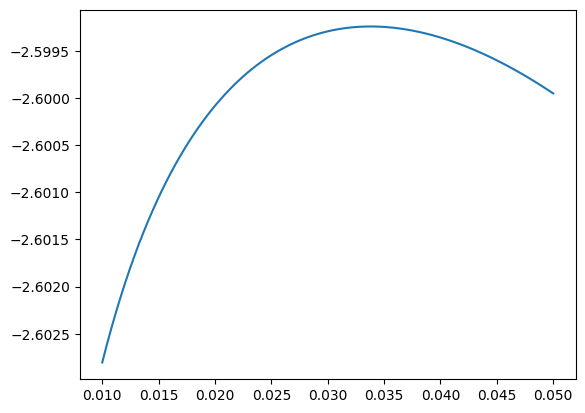

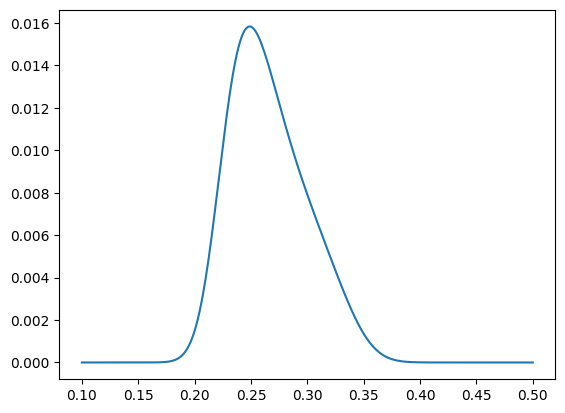

 84.380050 seconds (32.70 M allocations: 554.748 GiB, 20.49% gc time)
reg = rs[argmax(ss)] = 0.033838383838383834
mse(w_bin) = 0.001476364883838395


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3a9b733790>

In [226]:
# TODO: Binomial Model

m_bin = ObjectiveEmpiricalBayes.BinomialModel(N, xs)
reg_bin = 0

data_bin = round.(Int, data * N)
w_bin, reg = cverp(m_bin, data_bin, rs = linspace(0.01,0.05,100))

@show mse(w_bin)
figure()
plot(xs, w_bin)

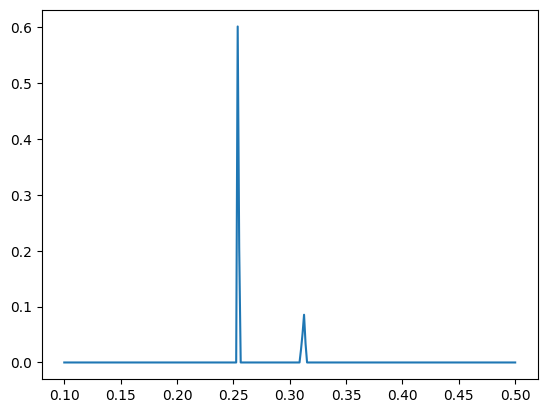

mse(w_bin) = 0.0014375774421283886


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3a9bb90950>

In [217]:
# TODO: Binomial Model

m_bin = ObjectiveEmpiricalBayes.BinomialModel(N, xs)
reg_bin = 0

w_bin = ebprior(m_bin,  round.(Int,data * N), ReferenceRegularizer(m_bin,  reg_bin), OPTCONFIG)

@show mse(w_bin)
plot(xs, w_bin)

In [265]:
data[i], 

18-element Array{Float64,1}:
 0.4  
 0.378
 0.356
 0.333
 0.311
 0.311
 0.289
 0.267
 0.244
 0.244
 0.222
 0.222
 0.222
 0.222
 0.222
 0.2  
 0.178
 0.156

In [296]:
PyPlot.cm.tab20(0.1)

(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)

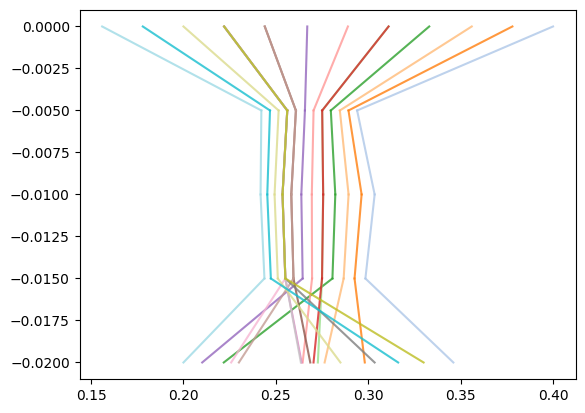

In [298]:
dots = hcat(data, posts, truth)
scale = scale=-5e-3

for i=1:size(dots, 1)
    for j=1:size(dots, 2)-1
        plot([dots[i,j], dots[i,j+1]], [j-1,j].*scale, alpha=0.8, c=PyPlot.cm.tab20(i/18))
    end
end

In [414]:
ax1

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3a9823c390>

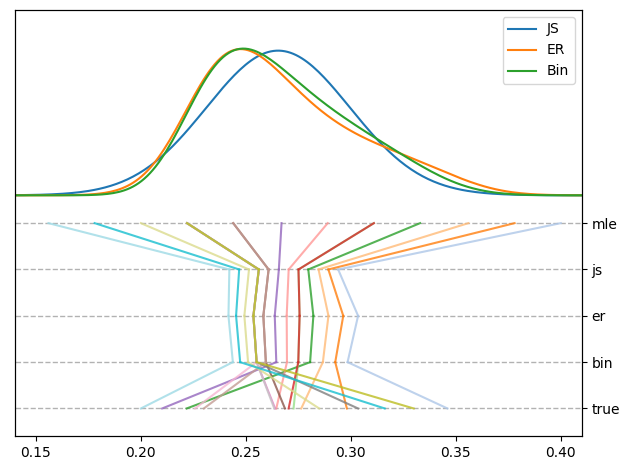

In [466]:
fig, ax1 = subplots()

xmin, xmax = .14, .41
ymin, ymax = -0.026, 0.02

plot(xs, w_js, label="JS")
plot(xs, w_er, label="ER")
plot(xs, w_bin, label="Bin")
legend()

#grid(which="major",axis="both", alpha=0.2)

xlim(xmin, xmax)
ylim(ymin, ymax)
ax1.set_yticks([])

#subplot(212, sharex=ax1)
offset = -0.003
scale=-5e-3

dots = hcat(data, posts, truth)
scale = scale=-5e-3

yt = vcat([0,1,2,3,4] .* scale.+offset)
ytl = vcat(["mle", "js", "er", "bin", "true"])

ax2 = ax1.twinx()
#ax2.yaxis.set_label_position("right")


ax2.set_ylim(ymin , ymax)
ax2.set_yticks(yt)
ax2.set_yticklabels(ytl)

ax2.hlines([0,1,2,3,4] .* scale.+offset, 0, 1, linewidth=1, alpha=0.3, linestyle="dashed")

for i=1:size(dots, 1)
    for j=1:size(dots, 2)-1
        ax2.plot([dots[i,j], dots[i,j+1]], [j-1,j].*scale.+offset, alpha=0.8, c=PyPlot.cm.tab20(i/18))
    end
end
fig.tight_layout()

In [312]:
[sqrt(sum((dots[:,j] - dots[:,i]).^2)) for i=1:5, j=1:5]

5×5 Array{Float64,2}:
 0.0       0.226238    0.213616    0.221864    0.292865
 0.226238  0.0         0.0150262   0.00707329  0.163696
 0.213616  0.0150262   0.0         0.00870541  0.163667
 0.221864  0.00707329  0.00870541  0.0         0.163017
 0.292865  0.163696    0.163667    0.163017    0.0     

In [239]:
@show mse(w_js)
@show mse(w_er)
@show mse(w_bin)

mse(w_js) = 0.0014886888941607502
mse(w_er) = 0.0014881672041191934
mse(w_bin) = 0.001476364883838395


0.001476364883838395

In [243]:
posts = hcat((posteriormeans(w) for w in [w_js, w_er, w_bin])...)

18×3 Array{Float64,2}:
 0.293979  0.303458  0.29846 
 0.289306  0.296399  0.292585
 0.284634  0.289349  0.286693
 0.279749  0.282162  0.280619
 0.275076  0.275606  0.274983
 0.275076  0.275606  0.274983
 0.270404  0.269461  0.269595
 0.265731  0.263779  0.264506
 0.260846  0.258347  0.259538
 0.260846  0.258347  0.259538
 0.256174  0.253618  0.255132
 0.256174  0.253618  0.255132
 0.256174  0.253618  0.255132
 0.256174  0.253618  0.255132
 0.256174  0.253618  0.255132
 0.251501  0.249305  0.251059
 0.246828  0.245359  0.247297
 0.242156  0.241731  0.243821

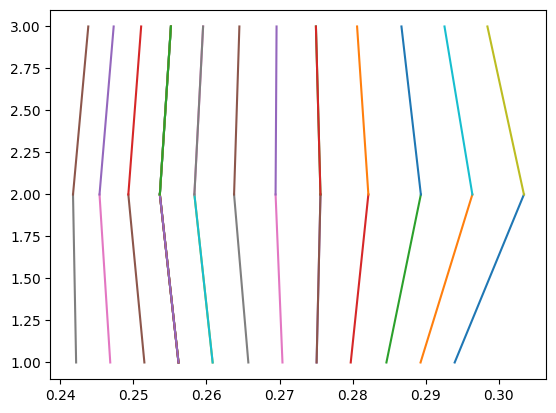

In [251]:
for i=1:18
    plot([posts[i,1], posts[i,2]], [0,-1])
end
for i=1:18
    plot([posts[i,2], posts[i,3]], [-1,-2])
end